# Experiment 2: What persists, exists

> Conducting the second experiment that is training the cellular automaton to maintain its form after it has reached the desired shape.

In [1]:
#| default_exp what_persists_exists

In [2]:
#| hide
# from nbdev.showdoc import *

In [3]:
#| export
# import NeuralCellularAutomata_PyTorch.custom_attention
from NeuralCellularAutomata_PyTorch.core import *
from NeuralCellularAutomata_PyTorch.core import COLOR_N
from NeuralCellularAutomata_PyTorch.learning_to_grow import *

# from NeuralCellularAutomata_PyTorch.core import CHANNEL_N, load_image, TARGET_SIZE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [4]:
batch_size = 1
# n_epochs = 200
CHANNEL_N = 64
COLOR_N = 3


core_diameter = 8

In [5]:
path = '../images/emoji_u1f98e.png'
# path = '../images/bw.png'

In [6]:
# dna = torch.rand([CHANNEL_N, core_diameter, core_diameter])
# dna = F.normalize(torch.randn([CHANNEL_N, 2, 2]), dim=0).abs()

# dna = (
#     torch.eye(CHANNEL_N)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([CHANNEL_N, core_diameter, core_diameter])
#     .flip(0)
# )

foo = (
    torch.eye(CHANNEL_N)[: 2**2]
    .movedim(0, -1)
    .reshape([CHANNEL_N, 2, 2])
    .flip(0)
)

# dna = (
#     torch.eye(core_diameter**2)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([core_diameter**2, core_diameter, core_diameter])
# )

# dna = F.interpolate(
#     torch.eye(core_diameter**2)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([core_diameter**2, core_diameter, core_diameter]),
#     size=(CHANNEL_N,core_diameter,core_diameter)
# )

# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 2), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 4), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 8), mode="circular").movedim(-1, 0)

# foo = torch.ones_like(dna)
# foo[:core_diameter**2] = (foo - dna)[:core_diameter**2]
# dna = foo

# dna = torch.ones_like(dna) - dna
# dna[:COLOR_N] = 0

dna = torch.zeros((CHANNEL_N, core_diameter, core_diameter))
for r, c in [
    (0, 0),
    (1, 0),
    (0, 1),
    (1, 1),
]:
    dna[:, r * (core_diameter - 1), c * (core_diameter - 1)] = foo[:, r, c]
    # dna[:, r * (core_diameter - 1), c * (core_diameter - 1)] = 0.0
# dna[:, 1:, 1:] = 0.0

dna = dna[:CHANNEL_N]

dna = dna * CHANNEL_N

print(dna.shape)
print(dna)

torch.Size([64, 8, 8])
tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0

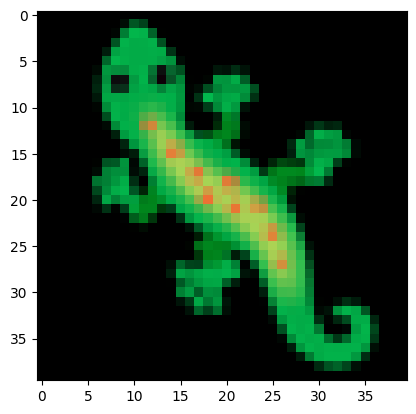

In [7]:
img_tensor = load_image(path)

# Pool Training

We want to create a pool of samples, that will contain different stages of the generation process as initial states.

In [8]:
# Samples
# | export
class SamplePool:
    def __init__(self, pool_size=1024, loss_fn=None, device=def_device):
        assert loss_fn is not None, "You need to provide a loss function"
        self.pool_size = pool_size
        self.loss_fn = loss_fn
        self.reset()

    def make_seed(self, sz=[1, CHANNEL_N, TARGET_SIZE, TARGET_SIZE]):
        seed = torch.zeros(sz).to(def_device)
        center_minus = (TARGET_SIZE - core_diameter) // 2
        center_plus = center_minus + core_diameter
        seed[:, :, center_minus:center_plus, center_minus:center_plus] = dna
        # seed[:, :, 5 : 5 + core_diameter, 5 : 5 + core_diameter] = dna
        return seed

    def reset(self):
        self.seed = self.make_seed()
        self.pool = self.seed.repeat(self.pool_size, 1, 1, 1)

    def sample(self, num_samples=8):
        # selecting a random sample from the pool
        self.idxs = torch.randperm(self.pool_size)[:num_samples]
        batch = self.pool[self.idxs, ...]

        # find the sample in the batch with the highest loss
        losses = self.loss_fn(batch[:, :COLOR_N, :, :])
        # and replace it with the seed
        # to avoid "catastrofic forgetting"
        # (i.e. forgetting how to generate the target from the seed)
        replace_idx = torch.argmax(losses).item()
        batch[replace_idx] = self.seed[0]

        return batch

    def update(self, new_samples):
        new_samples = new_samples.detach()
        # replace the old samples with the newly generated ones
        self.pool[self.idxs] = new_samples

In the SamplePool, we use a loss function to select the sample inside the batch with the highest loss and replace it with the original seed. To do so, we will use the MSE loss. 

In [9]:
# mse
#| export
def mse(pred, target, dim=1): 
    return ((pred - target) * (pred - target)).sum(dim).sum(dim=(1, 2))

In [10]:
loss_fn = partial(mse, target=img_tensor.repeat(batch_size, 1, 1, 1).to(def_device))

In [11]:
pool = SamplePool(16, loss_fn=loss_fn)
batch = pool.sample(batch_size) #TODO: fix ugly here
batch.shape

torch.Size([1, 64, 40, 40])

We also need a function that will visualize a batch of inputs to validate that the sampling of the pool works as expected.

In [12]:
def vis_batch(batch):
    B, C, H, W = batch.shape
    if C > COLOR_N:
        batch = batch[:, :COLOR_N, :, :]

    plt.figure(figsize=(16, 16))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        assert type(batch) is torch.Tensor
        plt.imshow(batch[i].detach().cpu().permute(1, 2, 0).clamp(0,1))
        plt.axis('off')    

    plt.show()
#| export 

In [13]:
# print(true_target.shape)
# vis_batch(model_in)

# Training Loop

In [14]:
# Instantiate the model
# |eval: false


repair = CAModel(CHANNEL_N, 1).to(def_device)
# embed = CAModel(CHANNEL_N, 1).to(def_device)
# repair = CAModel(CHANNEL_N, 1).to(def_device)


8 64 8 8


In [18]:
# dropout = nn.Dropout(7/8)

# full = nn.Sequential(embed,repair)

# Optimization

# ca.register_parameter("seed dna",dna)

lr = 2e-4
lr_gamma = 0.9999
betas = (0.5, 0.5)
# optimizer = torch.optim.Adam(full.parameters(), lr=lr, betas=betas)
optimizer = torch.optim.Adam(repair.parameters(), lr=lr, betas=betas)

# optimizer = torch.optim.Adam(ca.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

augment = torchvision.transforms.RandomRotation(360)

true_target = img_tensor.repeat(batch_size, 1, 1, 1)
# foo = list(batch.shape)
# foo[1] = COLOR_N
# target = img_tensor.broadcast_to(foo)
# target = img_tensor

  3%|▎         | 128/4096 [03:57<2:01:39,  1.84s/it]

Epoch: 128 Loss: 0.004569117911159992 Top: 10


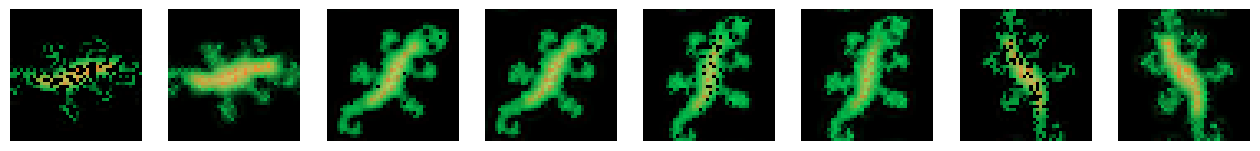

  6%|▋         | 256/4096 [08:09<2:01:44,  1.90s/it]

Epoch: 256 Loss: 0.0025795651599764824 Top: 11


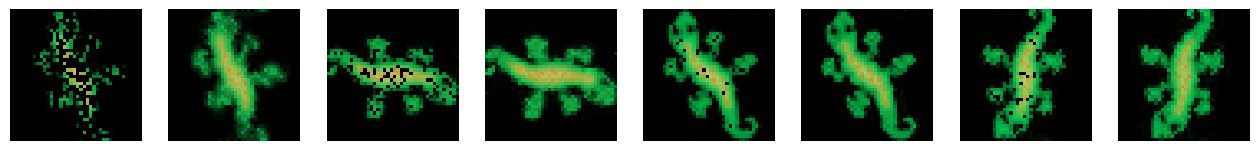

  9%|▉         | 384/4096 [12:31<2:16:57,  2.21s/it]

Epoch: 384 Loss: 0.002629263326525688 Top: 12


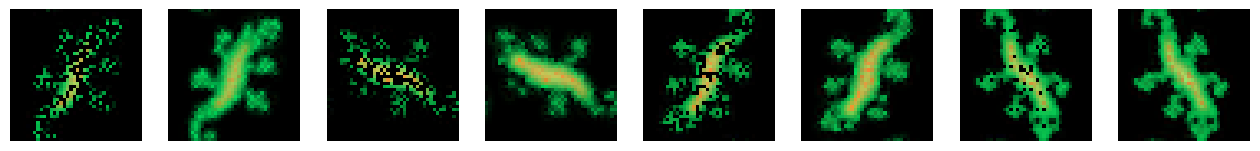

 12%|█▎        | 512/4096 [17:08<2:09:34,  2.17s/it]

Epoch: 512 Loss: 0.0031586899422109127 Top: 13


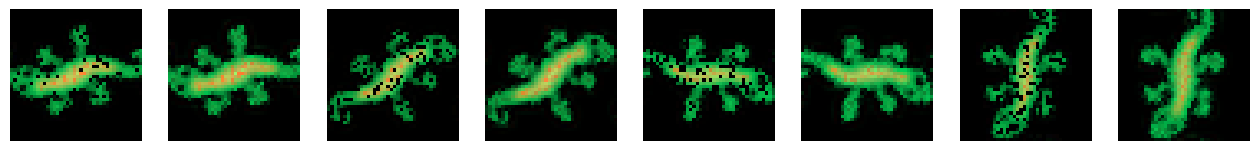

 16%|█▌        | 640/4096 [22:01<2:07:52,  2.22s/it]

Epoch: 640 Loss: 0.005300752818584442 Top: 14


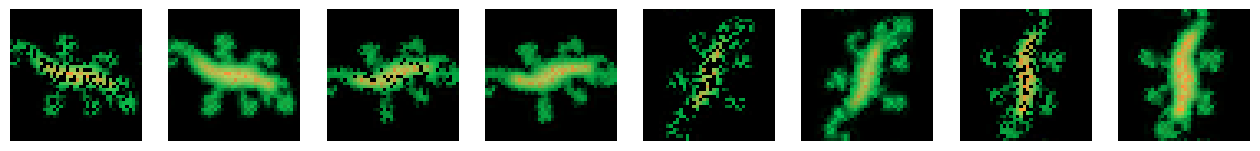

 19%|█▉        | 768/4096 [27:05<2:04:14,  2.24s/it]

Epoch: 768 Loss: 0.004148016218096018 Top: 15


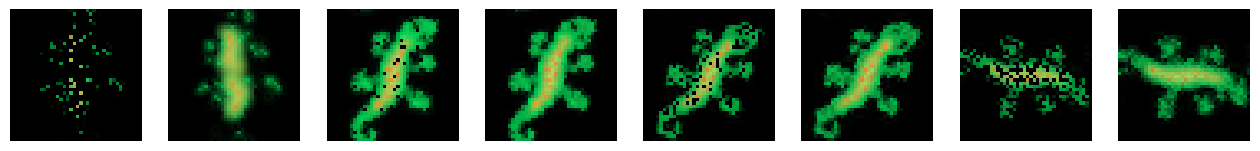

 22%|██▏       | 896/4096 [32:30<2:06:52,  2.38s/it]

Epoch: 896 Loss: 0.003362653311342001 Top: 16


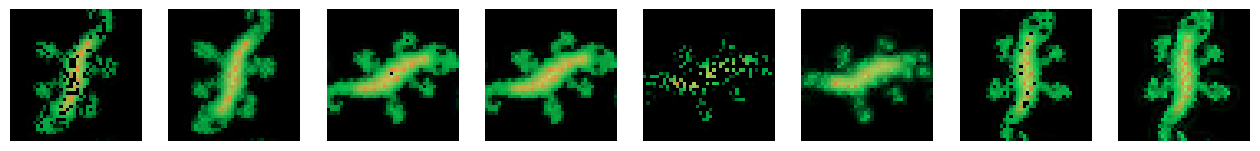

 25%|██▌       | 1024/4096 [38:02<2:01:54,  2.38s/it]

Epoch: 1024 Loss: 0.004784473683685064 Top: 17


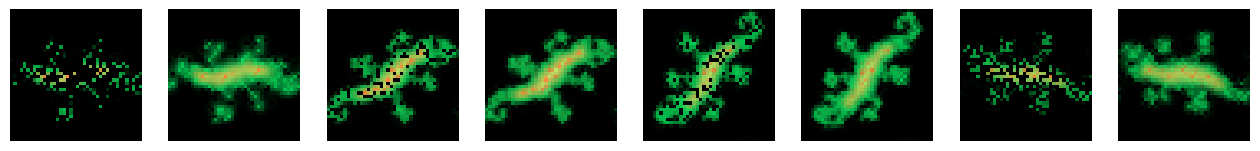

 28%|██▊       | 1152/4096 [43:47<2:02:55,  2.51s/it]

Epoch: 1152 Loss: 0.0038810432888567448 Top: 18


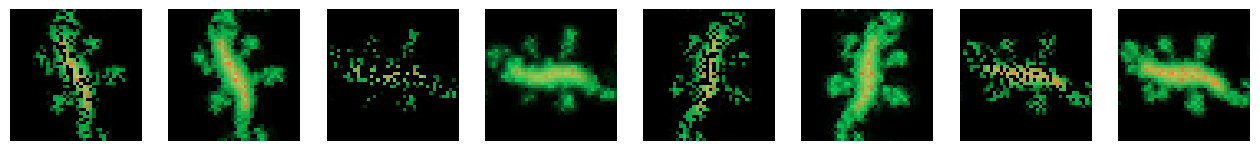

 31%|███▏      | 1280/4096 [49:39<2:27:30,  3.14s/it]

Epoch: 1280 Loss: 0.005977634806185961 Top: 19


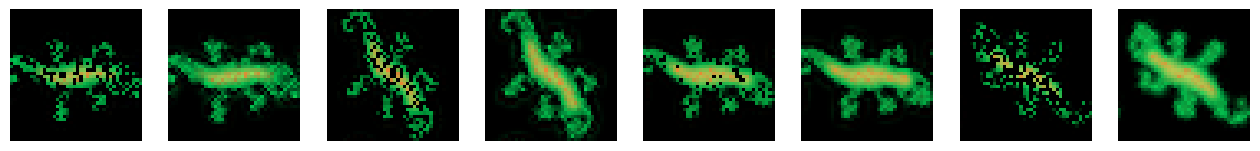

 34%|███▍      | 1408/4096 [55:54<2:00:09,  2.68s/it]

Epoch: 1408 Loss: 0.004051750060170889 Top: 20


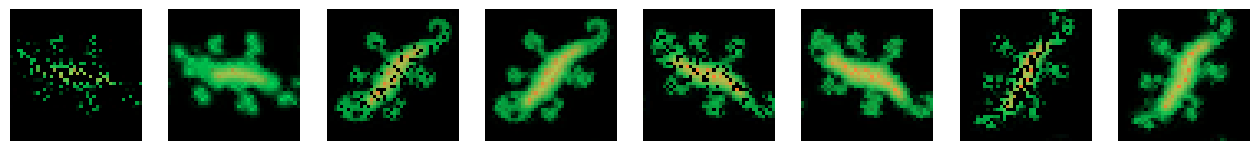

 38%|███▊      | 1536/4096 [1:02:07<2:11:34,  3.08s/it]

Epoch: 1536 Loss: 0.002261570654809475 Top: 21


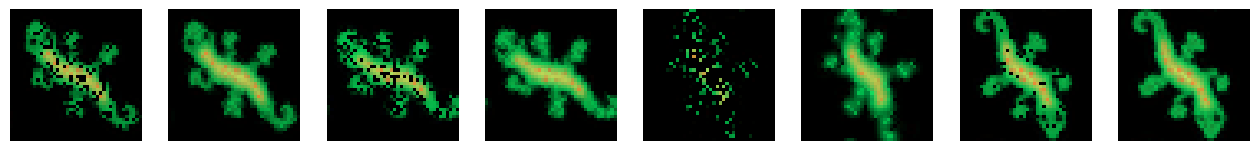

 41%|████      | 1664/4096 [1:08:45<2:26:09,  3.61s/it]

Epoch: 1664 Loss: 0.0030220807529985905 Top: 22


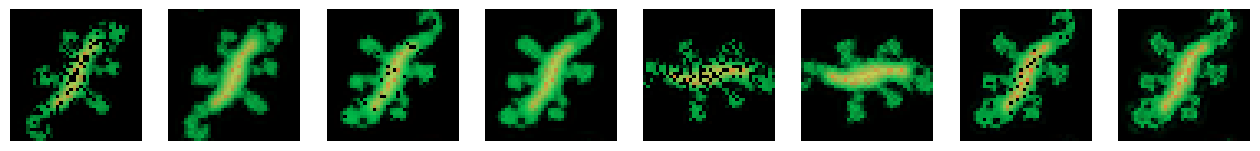

 44%|████▍     | 1792/4096 [1:15:43<2:01:23,  3.16s/it]

Epoch: 1792 Loss: 0.005517405457794666 Top: 23


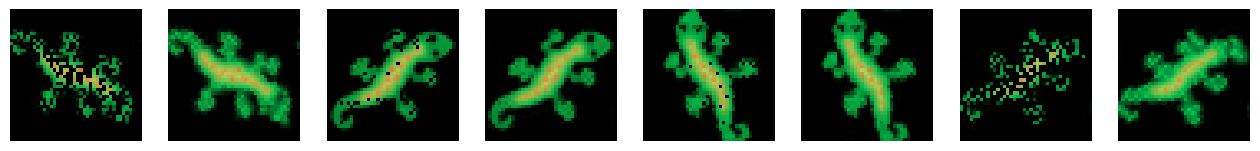

 47%|████▋     | 1920/4096 [1:22:55<2:31:08,  4.17s/it]

Epoch: 1920 Loss: 0.003398619359359145 Top: 24


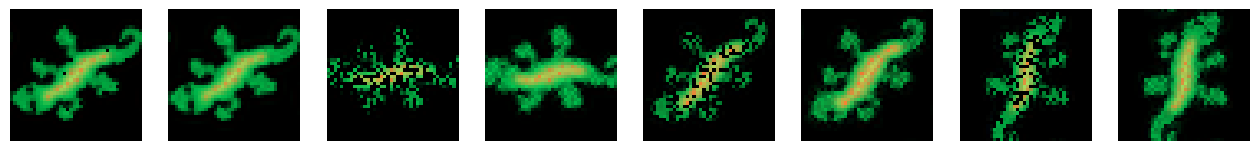

 50%|█████     | 2048/4096 [1:30:13<2:01:21,  3.56s/it]

Epoch: 2048 Loss: 0.0033284989185631275 Top: 25


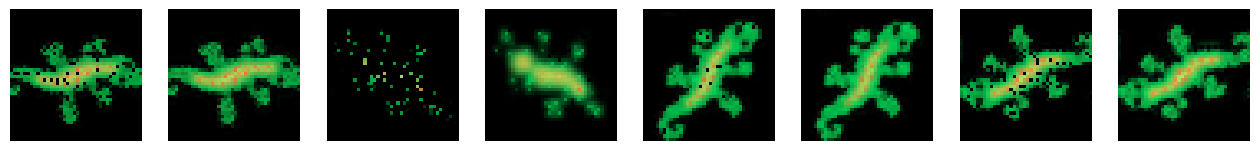

 53%|█████▎    | 2176/4096 [1:37:22<1:57:21,  3.67s/it]

Epoch: 2176 Loss: 0.0031966743990778923 Top: 26


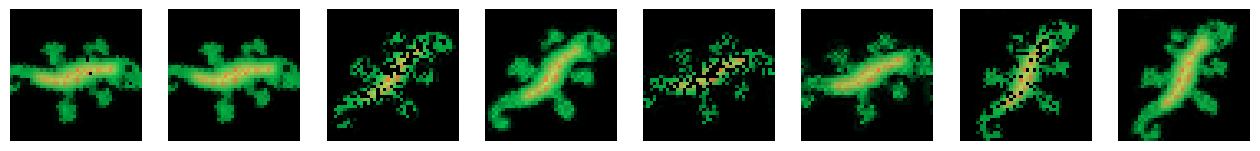

 56%|█████▋    | 2304/4096 [1:45:02<1:47:42,  3.61s/it]

Epoch: 2304 Loss: 0.00535008916631341 Top: 27


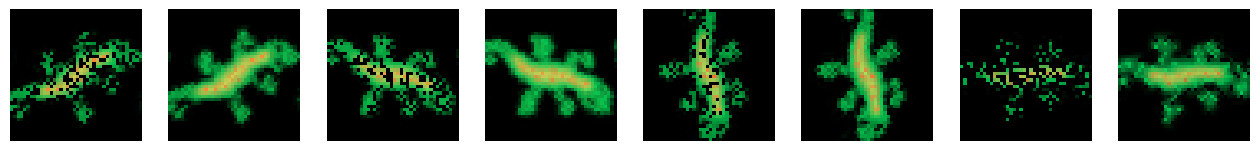

 59%|█████▉    | 2432/4096 [1:52:43<1:46:20,  3.83s/it]

Epoch: 2432 Loss: 0.006820897571742535 Top: 28


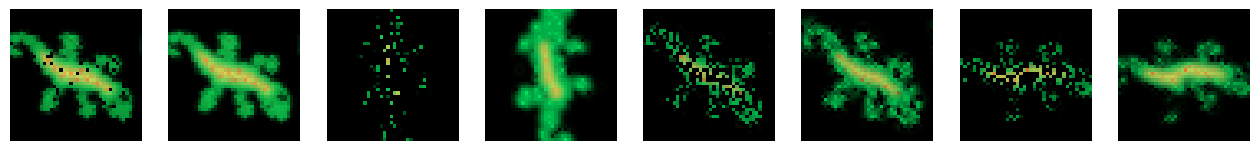

 62%|██████▎   | 2560/4096 [2:00:08<1:37:19,  3.80s/it]

Epoch: 2560 Loss: 0.004362092353403568 Top: 29


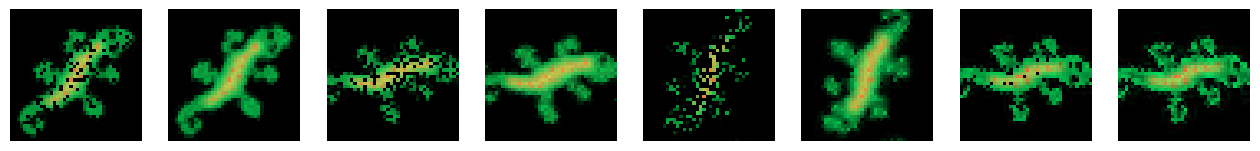

 66%|██████▌   | 2688/4096 [2:08:04<1:38:09,  4.18s/it]

Epoch: 2688 Loss: 0.002722084056586027 Top: 30


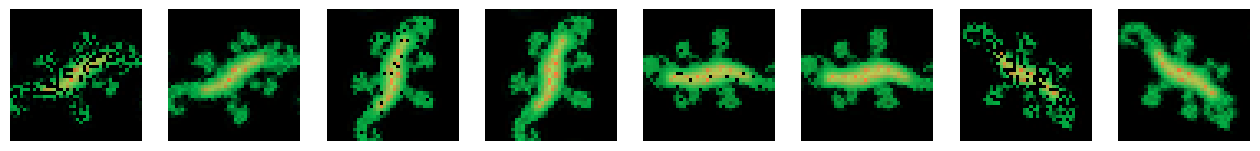

 69%|██████▉   | 2816/4096 [2:16:35<1:52:09,  5.26s/it]

Epoch: 2816 Loss: 0.0034059230238199234 Top: 31


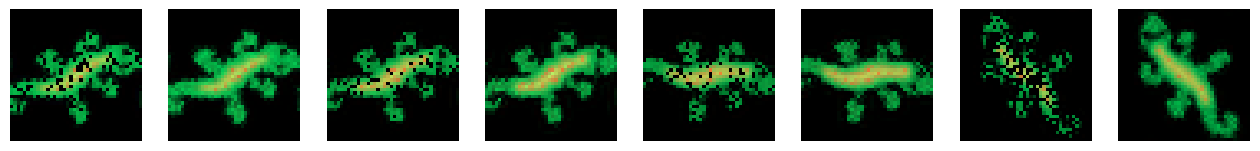

 72%|███████▏  | 2944/4096 [2:24:51<1:06:05,  3.44s/it]

Epoch: 2944 Loss: 0.005271960981190205 Top: 32


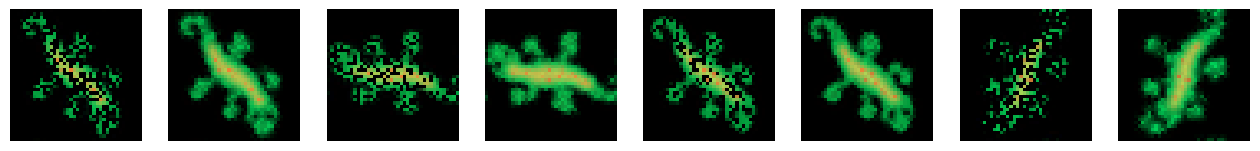

 75%|███████▌  | 3072/4096 [2:33:24<1:13:02,  4.28s/it]

Epoch: 3072 Loss: 0.004829706624150276 Top: 33


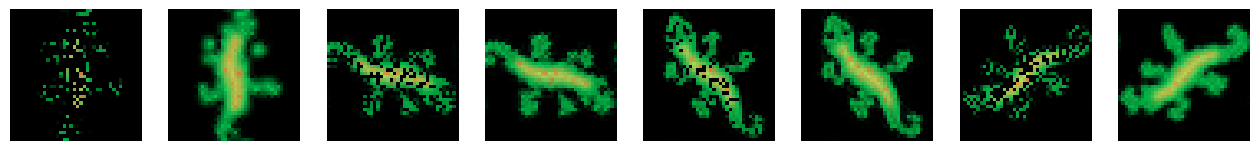

 78%|███████▊  | 3200/4096 [2:42:06<54:15,  3.63s/it]  

Epoch: 3200 Loss: 0.0013951754663139582 Top: 34


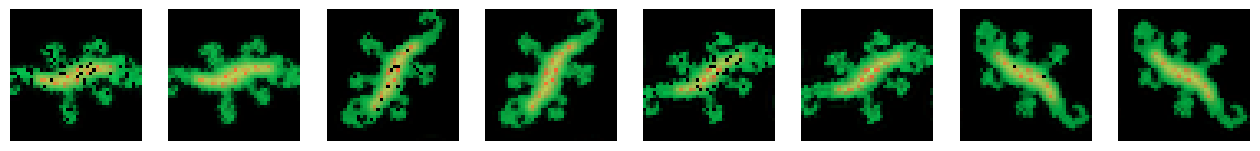

 81%|████████▏ | 3328/4096 [2:50:57<56:31,  4.42s/it]  

Epoch: 3328 Loss: 0.004290509037673473 Top: 35


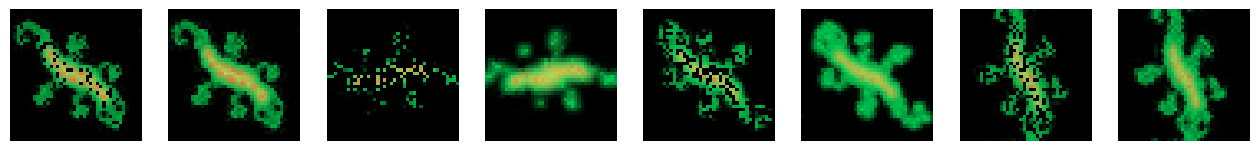

 84%|████████▍ | 3456/4096 [3:00:32<33:00,  3.10s/it]  

Epoch: 3456 Loss: 0.003071197774261236 Top: 36


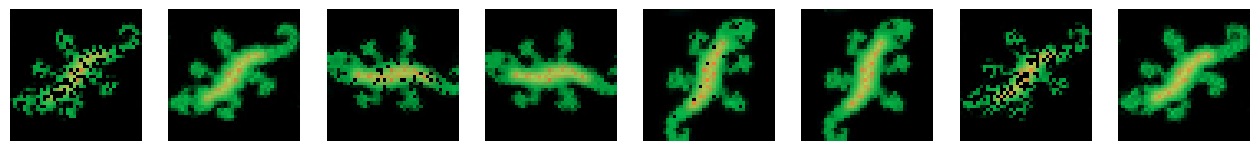

 88%|████████▊ | 3584/4096 [3:10:24<39:40,  4.65s/it]  

Epoch: 3584 Loss: 0.0034217715729027987 Top: 37


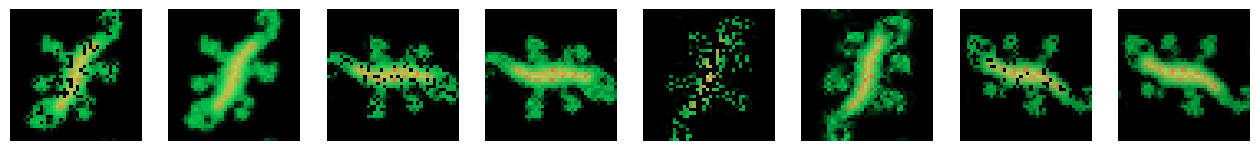

 91%|█████████ | 3712/4096 [3:20:09<29:46,  4.65s/it]

Epoch: 3712 Loss: 0.008882285095751286 Top: 38


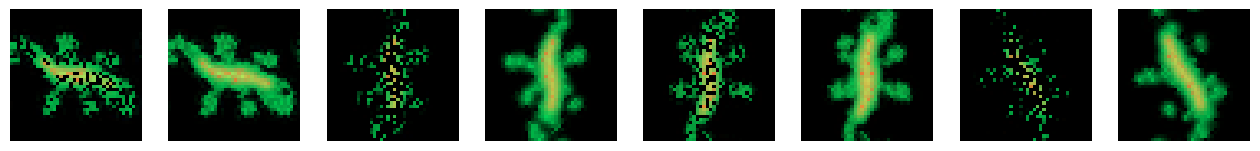

 94%|█████████▍| 3840/4096 [3:31:13<20:17,  4.76s/it]

Epoch: 3840 Loss: 0.004260824527591467 Top: 39


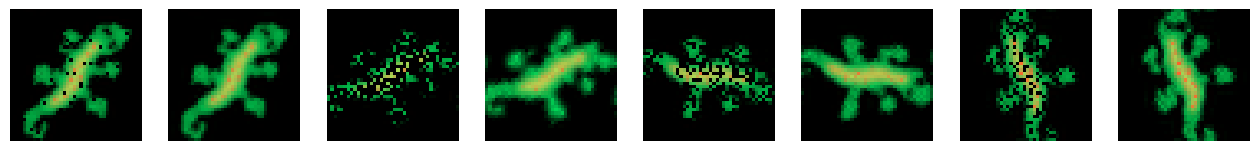

 97%|█████████▋| 3968/4096 [3:42:09<09:34,  4.49s/it]

Epoch: 3968 Loss: 0.007551646325737238 Top: 40


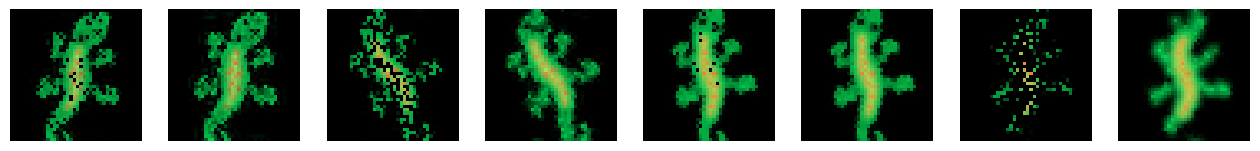

100%|██████████| 4096/4096 [3:53:32<00:00,  3.42s/it]


In [26]:
# run the training
# |eval: false

import math


chunk = 128
n_epochs = chunk * 32

model_in = torch.zeros_like(pool.sample(batch_size))
# model_in[:, :COLOR_N] = true_target[:, :COLOR_N]
# model_in = target[None,]


class Logger:
    def __init__(self) -> None:
        self.l = []

    def i(self, it):
        self.l.append(it)

    def o(self, a):
        out = []
        for i in a:
            out.append(self.l[i])
        out = torch.cat(out)
        self.l.clear()
        return out


def dropout(res, ratio):
    mask = torch.rand_like(res[:, 0:1, : TARGET_SIZE // 1, : TARGET_SIZE // 1])
    mask = F.interpolate(mask, res.shape[2:], mode="bilinear")
    mask = (mask + ratio).floor().clamp(0, 1)
    return res * mask


log: Logger = Logger()

for i in tqdm(range(n_epochs)):
    # zero the optimizer
    optimizer.zero_grad()

    # set the number of steps to take
    top = 1
    bot = 0
    top += i // chunk * 1
    # bot += i // chunk * 1
    top += 8
    bot += 8
    steps = torch.randint(bot, top, (1,)).item()
    steps += 1

    # model_in = true_target

    # model_in = torch.zeros_like(pool.sample(batch_size))
    model_in[:, :COLOR_N] = true_target[:, :COLOR_N]
    model_in[:, :COLOR_N] = augment(true_target)[:, :COLOR_N]
    res = model_in
    # log.i(res)

    res = repair(res, steps=steps)
    # log.i(res)

    loss = torch.zeros(1)

    loss += F.mse_loss(res[:, :COLOR_N], model_in[:, :COLOR_N])

    res = dropout(res, torch.rand((1,)).item() ** 0.5)
    log.i(res)

    res = repair(res, steps=steps)
    loss += F.mse_loss(res[:, :COLOR_N], model_in[:, :COLOR_N])
    log.i(res)

    if i % (chunk) == 0 and i != 0:
        print(f"Epoch: {i} Loss: {loss.item()} Top: {top}")
        vis_batch(
            log.o(
                range(-8, 0),
            )
        )

    # backpropagate the loss and update the weights
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
torch.set_printoptions(profile="full")
print(repair.state_dict())
torch.set_printoptions(profile="default")
# # import save1
# # ca.load_state_dict(save1.getSave())


OrderedDict({'brain.0.weight': tensor([[ 4.0177e-02, -8.0040e-02,  3.1339e-03, -1.2629e-01,  6.6311e-02,
         -3.4931e-03,  1.2199e-01, -4.6503e-02, -7.5570e-02, -5.0660e-02,
          1.8829e-02,  5.5502e-02, -2.2101e-02, -1.0383e-01, -2.4217e-02,
         -2.5215e-02,  8.4225e-02,  1.3592e-01, -3.2909e-02, -7.7804e-02,
          9.5502e-02, -5.7541e-02,  4.4740e-02,  5.6865e-02,  9.2026e-02,
         -4.2287e-03,  3.4921e-02, -1.0813e-01,  3.8611e-02, -8.2837e-02,
         -1.1097e-01, -4.3461e-02, -2.5916e-02, -5.5847e-02,  1.1110e-01,
         -5.5322e-02,  1.1611e-01,  3.8637e-02, -4.8668e-02, -3.1003e-02,
         -7.2095e-02,  5.8801e-02,  2.9803e-02,  2.3849e-02, -3.7022e-02,
         -5.3692e-02, -1.1902e-01,  1.8202e-02, -8.4823e-02, -1.0949e-01,
         -8.5358e-02, -4.1579e-02, -1.2355e-01, -4.3274e-02, -7.4348e-02,
          1.2781e-02, -9.7818e-02,  2.2801e-02, -3.8613e-02,  7.8721e-02,
          1.1068e-02, -2.6541e-02,  2.8646e-02, -8.2207e-02],
        [-1.2766e-0

In [ ]:
# torch.save(repair.state_dict(),"save1.pt") # TAKEN


In [25]:
# |eval: false

# assert type(embed) is CAModel
# assert type(repair.grow_animation) is function

images = repair.grow_animation(model_in, 64)
# display_animation(images)

images = images + repair.grow_animation(dropout(repair(model_in,64),0.5), 64)

for i in range(0,len(images)):
    # print(images[i].shape)
    images[i] = images[i][...,:COLOR_N]

display_animation(images)

The automato manages to maintain it's shape as time passes. 

### Visualize a batch from the updated pool. 

During the training process we update the samples inside the pool. 
Let's visualize how a sample would look like after the training process is completed. 

In [ ]:
#| eval: false
batch = pool.sample(batch_size)
#| eval: false
vis_batch(batch)